## MCIT - AWS Training Use Case 2

 <a name="0"></a>
 
In this nootebok, wel will work on the **Consumer Reviews of Amazon Products** from [__kaggle__](https://www.kaggle.com/datafiniti/consumer-reviews-of-amazon-products).

We will pre-process the text in review, build multiple models and compare their performances.

1. <a href="#1">Problem Definition</a>
2. <a href="#2">Data Definition</a>
3. <a href="#3">Read the dataset</a>
4. <a href="#4">Exploratory Data Analysis(EDA)</a>
5. <a href="#5">Pre-Processing</a>
5. <a href="#6">Feature Engineering</a>
6. <a href="#7">Model Training</a>

### 1. <a name="1">Problem Definition</a>
(<a href="#0">Go to top</a>)

The problem is to identify the customer reviews on the products.

Predict whether the review is a `POSITIVE` one or a `NEGATIVE` one, based on the sentiment analysis from old & labled reviews from different customers on different products.

### 2. <a name="2">Data Definition</a>
(<a href="#0">Go to top</a>)

[__Official Documentation__](https://developer.datafiniti.co/docs/product-data-schema)

- `id`: -----
- `name`: The product's name.
- `asins`: The ASIN (Amazon identifier) used for this product.
- `brand`: The brand name of this product.
- `categories`: A list of category keywords used for this product across multiple sources.
- `keys`: A list of internal Datafiniti identifiers for this product.
- `manufacturer`: The manufacturer of this product.
- `reviews.date`: The date the review was posted.
- `reviews.dateAdded`: -----
- `reviews.dateSeen`: The date when the review was seen by Datafiniti.
- `reviews.didPurchase`: A true/false for whether or not the reviewer did purchase the product.
- `reviews.doRecommend`: A true/false for whether or not the reviewer recommends the product.
- `reviews.id`: The website ID associated with this review.
- `reviews.numHelpful`: The number of people that found this review helpful.
- `reviews.rating`: A 1 to 5 start value for the review.
- `reviews.sourceURLs`: A list of URLs where this review was seen.
- `reviews.text`: The full (or available) text of the review.
- `reviews.title`: The review's title.
- `reviews.userCity`: The reviewer's city.
- `reviews.userProvince`: The reviewer's province or state.
- `reviews.username`: The reviewer's username.

In [1]:
# # Install & Upgrade Dependencies
# !pip install --upgrade pip
# !pip install --upgrade pandas
# !pip install --upgrade numpy
# !pip install --upgrade nltk
# !pip install --upgrade wordcloud
# !pip install --upgrade xgboost
# !pip install --upgrade scikit-learn
# !pip install --upgrade matplotlib

In [2]:
import re
from collections import Counter
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# % matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/btengana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/btengana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/btengana/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/btengana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Some constants
use_dataset_size = -1
random_state = 42
max_vector_features = 10000
balance_dataset_classes = True

### 3. <a name="3">Read Dataset</a>
(<a href="#0">Go to top</a>)

In [4]:
dataset_path = 'Consumer Reviews of Amazon Products.csv'
df = pd.read_csv(dataset_path, low_memory=False)

if use_dataset_size != -1:
    df = shuffle(df)
    df = df.head(use_dataset_size)

### 4. <a name="4">Exploratory Data Analysis(EDA)</a>
(<a href="#0">Go to top</a>)

We will take a look at number of rows, columns and some simple visualizations of the dataset.

In [5]:
print('Dataset Shape is:', df.shape)

Dataset Shape is: (34660, 21)


In [6]:
# View dataframe content
df.head(10)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42
5,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This amazon fire 8 inch tablet is the perfect ...,Just what we expected,NaN,NaN,tklit
6,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,"Great for e-reading on the go, nice and light ...",great e-reader tablet,NaN,NaN,Droi
7,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,"I gave this as a Christmas gift to my inlaws, ...",Great for gifts,NaN,NaN,Kacy
8,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",

In [7]:
# List dataset columns
df.columns

Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')

In [8]:
# Check data-types and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

In [9]:
# Check null values in each column
df.isna().sum()

id                          0
name                     6760
asins                       2
brand                       0
categories                  0
keys                        0
manufacturer                0
reviews.date               39
reviews.dateAdded       10621
reviews.dateSeen            0
reviews.didPurchase     34659
reviews.doRecommend       594
reviews.id              34659
reviews.numHelpful        529
reviews.rating             33
reviews.sourceURLs          0
reviews.text                1
reviews.title               5
reviews.userCity        34660
reviews.userProvince    34660
reviews.username            2
dtype: int64

In [10]:
# Count unique values in each column
df.nunique()

id                         42
name                       48
asins                      41
brand                       6
categories                 41
keys                       42
manufacturer                2
reviews.date             1078
reviews.dateAdded        1941
reviews.dateSeen         3911
reviews.didPurchase         1
reviews.doRecommend         2
reviews.id                  1
reviews.numHelpful         97
reviews.rating              5
reviews.sourceURLs      11929
reviews.text            34659
reviews.title           19767
reviews.userCity            0
reviews.userProvince        0
reviews.username        26789
dtype: int64

5.0    23775
4.0     8541
3.0     1499
1.0      410
2.0      402
Name: reviews.rating, dtype: int64


array([[<AxesSubplot:title={'center':'reviews.rating'}>]], dtype=object)

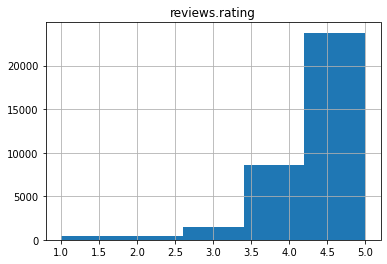

In [11]:
# View Rating Distribution
print(df['reviews.rating'].value_counts(sort=True))
df.hist(column='reviews.rating', bins=5)

In [12]:
# View words/tokens
results = Counter()

df[df['reviews.text'].notna()]['reviews.text'].str.lower().str.split().apply(results.update)

print(results)

Counter({'the': 43961, 'and': 33707, 'to': 33557, 'i': 31427, 'for': 26019, 'a': 24943, 'it': 24544, 'is': 20687, 'my': 17317, 'this': 17062, 'of': 11061, 'great': 10106, 'with': 9302, 'on': 7989, 'have': 7951, 'you': 7734, 'that': 7230, 'in': 6891, 'but': 6674, 'love': 6489, 'tablet': 6480, 'was': 6477, 'as': 6397, 'easy': 5944, 'so': 5941, 'very': 5707, 'use': 5447, 'not': 5414, 'can': 5404, 'amazon': 5311, 'bought': 4994, 'good': 4355, 'fire': 4306, 'kindle': 4289, 'it.': 4166, 'one': 4140, 'she': 4007, "it's": 3969, 'has': 3958, 'all': 3811, 'are': 3738, 'like': 3706, 'an': 3678, 'we': 3497, 'be': 3356, 'would': 3160, 'at': 3049, 'just': 3043, 'or': 3040, 'if': 2999, 'works': 2992, 'get': 2930, 'more': 2911, 'had': 2872, 'they': 2852, 'up': 2799, 'than': 2625, 'loves': 2619, 'from': 2551, 'much': 2495, 'when': 2404, 'really': 2373, 'tv': 2361, 'read': 2354, 'price': 2279, 'best': 2245, 'what': 2236, 'product': 2201, 'echo': 2152, 'only': 2127, 'purchased': 2123, 'no': 2090, 'your':

In [13]:
def describeTextFeature(data):
    wordcloud = WordCloud(random_state=random_state).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

Review Title / Positive Word-Cloud.

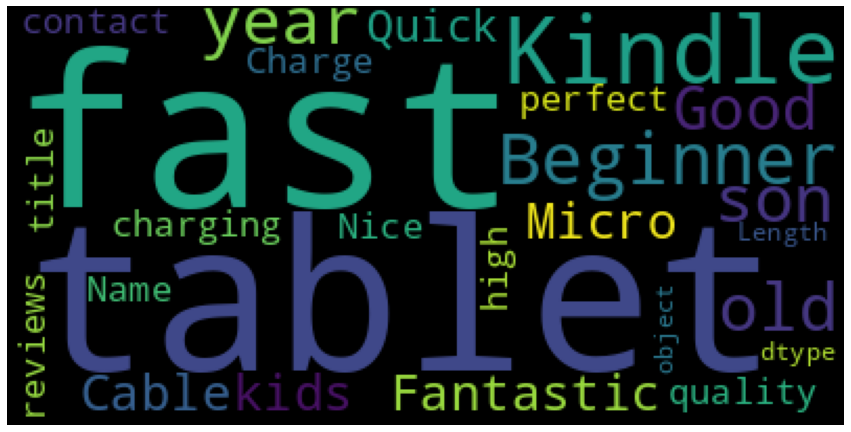

In [14]:
describeTextFeature(df[df["reviews.rating"] > 3]["reviews.title"])

Review Title / Neutral Word-Cloud.

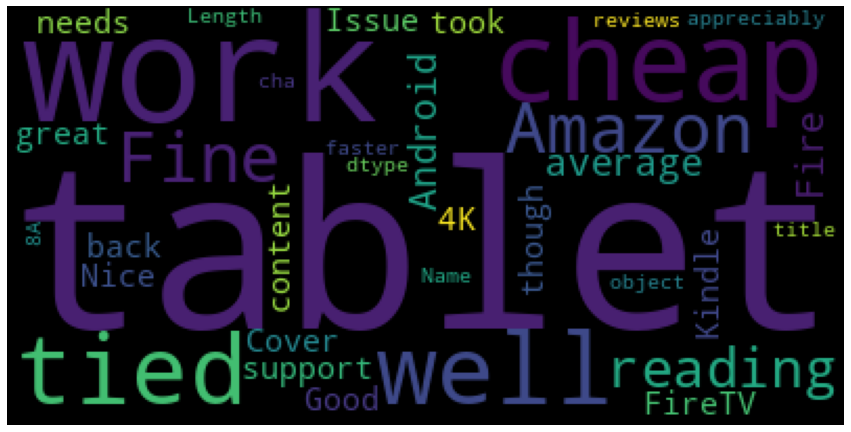

In [15]:
describeTextFeature(df[df["reviews.rating"] == 3]["reviews.title"])

Review Title / Negative Word-Cloud.

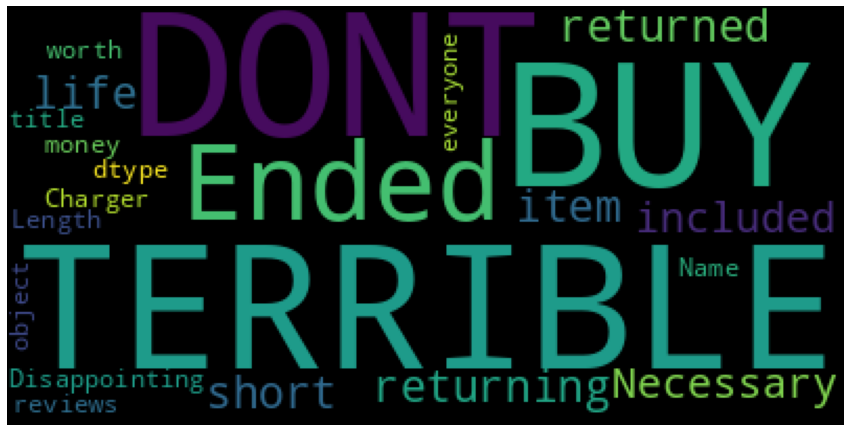

In [16]:
describeTextFeature(df[df["reviews.rating"] < 3]["reviews.title"])

### 5. <a name="5">Pre-Processing</a>
(<a href="#0">Go to top</a>)

Prepare/pre-process dataset features.

We will do a cleaning on the data before training the models on it.
The cleaning is:
- Drop unimportant features.
- Balance dataset.
- Shuffle dataset.
- Convert rating number to `0`, `1`, `2`.
- Drop Null datapoints.
- Prepare reviews text.
    1. Lowercase the reviews.
    2. Trim reviews.
    3. Remove unneeded review words(tags, hashtags, ...etc.)
    4. Tokenize reviews.
    5. Remove stopwords.
    6. Stem tokens.
    7. Lemming tokens.
- Make Feature Vector
    1. Count Vectorizer
    2. N-Gram
    3. Term Frequency (TF)
    4. Term Frequency - Inverted Document Frequency (TF-IDF)

Drop unimportant features.

In [17]:
df_cleaned = df.filter(['reviews.rating', 'reviews.text'])
df_cleaned.columns = ['rate', 'review']

Convert rating number to `POSITIVE`, `NEUTRAL` & `NEGATIVE`.

In [18]:
df_cleaned['rate'] = df_cleaned['rate'].apply(lambda x: 2 if x > 3 else(0 if x < 3 else 1))

Drop Null datapoints.

In [19]:
df_cleaned.dropna(inplace=True)

Balance Dataset

In [20]:
if balance_dataset_classes:
    min_class_datapoint = df_cleaned['rate'].value_counts().min()
    df_cleaned = df_cleaned.groupby('rate').apply(lambda x: x.sample(min_class_datapoint)).reset_index(drop=True)
    
    print('Undersampling the classes to', min_class_datapoint, 'datapoint in each class.')
    print('Dataset Shape is:', df_cleaned.shape)

Undersampling the classes to 812 datapoint in each class.
Dataset Shape is: (2436, 2)


Suffle dataset.

In [21]:
df_cleaned = shuffle(df_cleaned)

Prepare reviews text.

    1. Lowercase the reviews.
    2. Trim reviews.
    3. Remove unneeded review words(tags, hashtags, ...etc.)
    4. Tokenize reviews.
    5. Remove stopwords.
    6. Stem tokens.
    7. Lemming tokens.

In [22]:
def cleanReview(review):
    # Lowercase
    review = review.lower()
    # Removing URLs
    review = re.sub(r'^https?:\/\/.*[\r\n]*', '', review, flags = re.MULTILINE)
    # Removing accounts tag(@Ali)
    review = re.sub(r'@\w+', '', review, flags = re.MULTILINE)
    # Removing Punctuation
    review = re.sub(r'[^\w\s]','', review, flags = re.MULTILINE)
    # Remove HTML tags/markups
    review = re.sub(r'<.*?>', '', review, flags = re.MULTILINE)
    # Remove Numbers
    review = re.sub(r'\d+', '', review, flags = re.MULTILINE)
    # Trim
    review = review.lower()
    
    return review

df_cleaned['review'] = df_cleaned['review'].apply(lambda x: cleanReview(x))

In [23]:
sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
stopwords = nltk.corpus.stopwords.words('english')
Stemmer = PorterStemmer()
Lemmatizer = WordNetLemmatizer()

# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [24]:
def tokenize_stem_lem_review_tokens(review):
    global AllTokens
    
    # Tokenize Sentement
    tokens = word_tokenize(review)
    
    # Remove Stopwords
    tokens = [token for token in tokens if token not in stopwords]
    
    # Stem Tokens
    tokens = [Stemmer.stem(token) for token in tokens]
    
    # Lem Tokens
    tokens_pos_tags = nltk.pos_tag(tokens)
    tokens = [
        Lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1]))
        for (idx, tag) in enumerate(tokens_pos_tags)
    ]
    
    # Join Tokens
    review = ' '.join(tokens)
    
    return review

In [25]:
df_cleaned['review'] = df_cleaned['review'].apply(lambda x: tokenize_stem_lem_review_tokens(x))

Make Feature Vector

    1. Count Vectorizer
    2. N-Gram
    3. Term Frequency (TF)
    4. Term Frequency - Inverted Document Frequency (TF-IDF)

In [26]:
count_vectorizer = CountVectorizer(binary=True)
count_vectorizer.fit(df_cleaned['review'])
features = count_vectorizer.transform(df_cleaned['review'])

count_vectorizer_df = pd.DataFrame(features.toarray(), columns=count_vectorizer.get_feature_names())
count_vectorizer_df['rate'] = df_cleaned['rate'].values

In [27]:
ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
ngram_vectorizer.fit(df_cleaned['review'])
features = ngram_vectorizer.transform(df_cleaned['review'])

ngram_vectorizer_df = pd.DataFrame(features.toarray(), columns=ngram_vectorizer.get_feature_names())
ngram_vectorizer_df['rate'] = df_cleaned['rate'].values

In [28]:
tf_vectorizer = TfidfVectorizer(use_idf=False)
tf_vectorizer.fit(df_cleaned['review'])
features = tf_vectorizer.transform(df_cleaned['review'])

tf_vectorizer_df = pd.DataFrame(features.toarray(), columns=tf_vectorizer.get_feature_names())
tf_vectorizer_df['rate'] = df_cleaned['rate'].values

In [29]:
tfidf_vectorizer = TfidfVectorizer(use_idf=False)
tfidf_vectorizer.fit(df_cleaned['review'])
features = tfidf_vectorizer.transform(df_cleaned['review'])

tfidf_vectorizer_df = pd.DataFrame(features.toarray(), columns=tfidf_vectorizer.get_feature_names())
tfidf_vectorizer_df['rate'] = df_cleaned['rate'].values

### 7. <a name="7">Model Training</a>
(<a href="#0">Go to top</a>)

1. Split dataset.
2. Traing machine learning models:
    - Binary Count Vector:
        1. Naive Bayes
        2. Logistic Regression
        3. XGBClassifier
    - N-Gram Vector:
        1. Naive Bayes
        2. Logistic Regression
        3. XGBClassifier
    - Term Frequency (TF) Vector:
        1. Naive Bayes
        2. Logistic Regression
        3. XGBClassifier
    - Term Frequency - Inverted Document Frequency (TF-IDF) Vector:
        1. Naive Bayes
        2. Logistic Regression
        3. XGBClassifier
3. Evaluate models

In [30]:
# Split dataset function
def split_dataset(df):
    X_train, X_test, y_train, y_test = train_test_split(
        df.loc[:, df.columns != 'rate'],
        df['rate'],
        test_size=0.20,
        random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

In [31]:
def plot_confusion_matrix(cm, classes, normalize, title):
    """
    Create a confusion matrix plot for 'good' and 'bad' rating values 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.ocean)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [32]:
def disp_confusion_matrix(y_pred, y_test, model_name, feature_vector_name):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(
        cm,
        ['0', '1', '2'],
        False,
        model_name + "\n" + 'with' + "\n" + feature_vector_name + "\nConfusion Matrix"
    )
    plt.show()

In [33]:
def train_evaluate_model(Model, dataset, model_name, feature_vector_name):
    model = Model()
    
    # Split Dataset
    X_train, X_test, y_train, y_test = split_dataset(dataset)
    
    # Fitting classifier to the Training set (all features)
    model.fit(X_train, y_train)
    
    # Predicting the Test set results
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    disp_confusion_matrix(y_pred, y_test, model_name, feature_vector_name)

In [34]:
def run_models(models, df, feature_vector_name):
    for model in models:
        train_evaluate_model(model['model'], df, model['name'], feature_vector_name)

In [35]:
models = [
    {
        'model': MultinomialNB,
        'name': 'Naive Bayes'
    },
    {
        'model': LogisticRegression,
        'name': 'Logistic Regression'
    },
    {
        'model': XGBClassifier,
        'name': 'XGBClassifier'
    }
]

#### Binary Count Vector

              precision    recall  f1-score   support

           0       0.67      0.66      0.67       168
           1       0.51      0.46      0.49       166
           2       0.65      0.72      0.68       154

    accuracy                           0.61       488
   macro avg       0.61      0.62      0.61       488
weighted avg       0.61      0.61      0.61       488



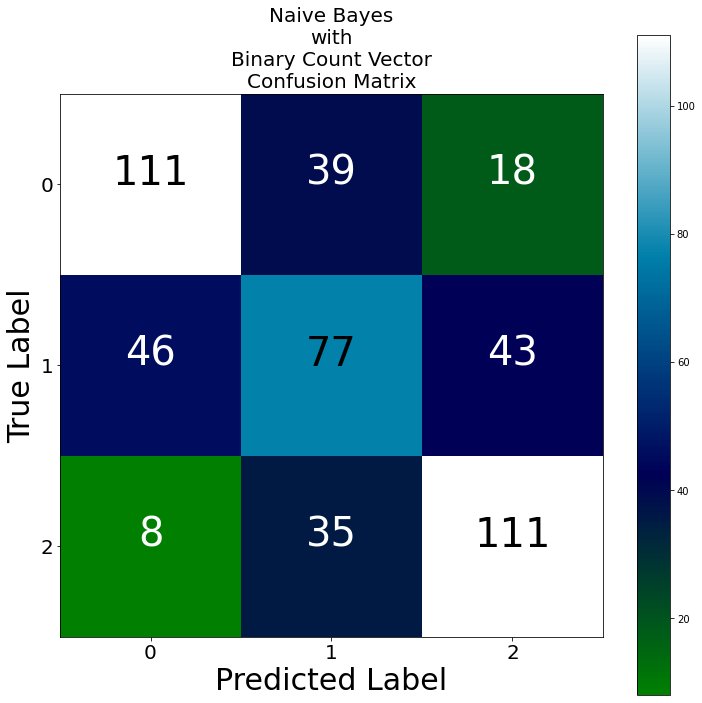

              precision    recall  f1-score   support

           0       0.69      0.65      0.67       168
           1       0.53      0.51      0.52       166
           2       0.64      0.71      0.68       154

    accuracy                           0.62       488
   macro avg       0.62      0.63      0.62       488
weighted avg       0.62      0.62      0.62       488



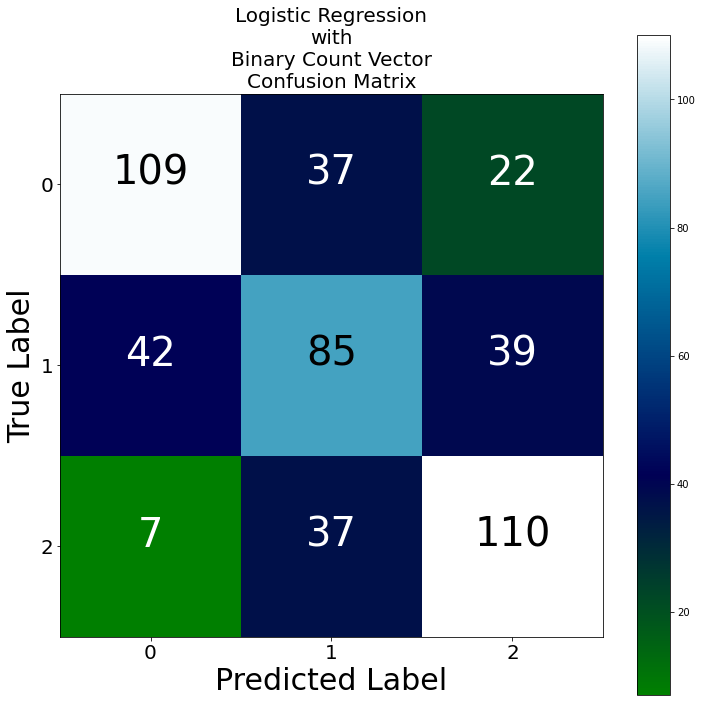

/home/btengana/workspace/MCIT/env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.68      0.62      0.65       168
           1       0.53      0.54      0.53       166
           2       0.65      0.69      0.67       154

    accuracy                           0.61       488
   macro avg       0.62      0.62      0.62       488
weighted avg       0.62      0.61      0.61       488



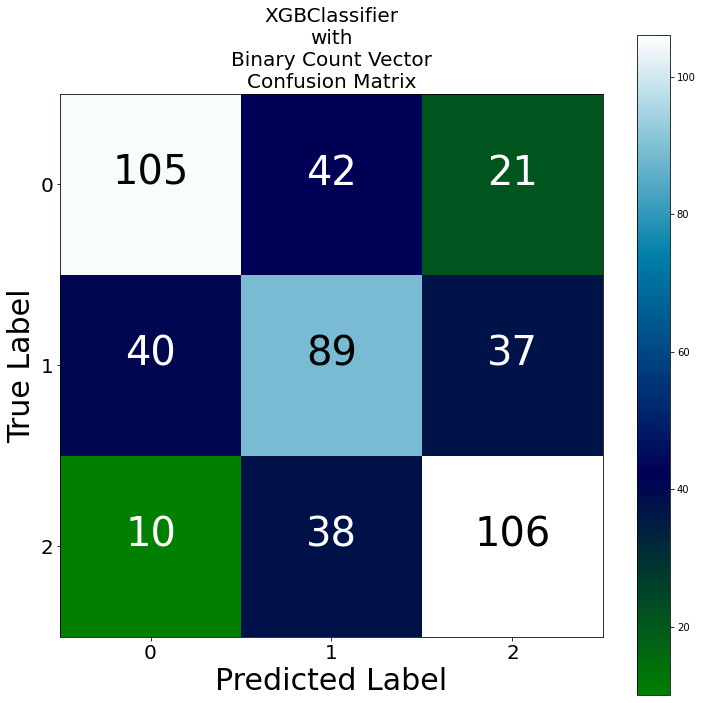

In [36]:
run_models(models, count_vectorizer_df, 'Binary Count Vector')

#### N-Gram Vector

              precision    recall  f1-score   support

           0       0.68      0.64      0.66       168
           1       0.52      0.49      0.51       166
           2       0.67      0.74      0.70       154

    accuracy                           0.62       488
   macro avg       0.62      0.63      0.62       488
weighted avg       0.62      0.62      0.62       488



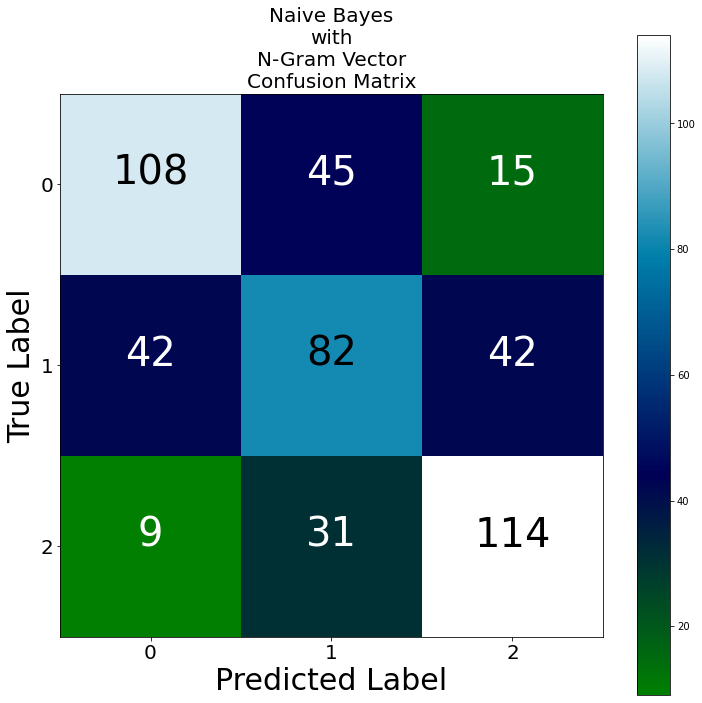

              precision    recall  f1-score   support

           0       0.71      0.64      0.67       168
           1       0.53      0.54      0.53       166
           2       0.66      0.73      0.69       154

    accuracy                           0.63       488
   macro avg       0.63      0.63      0.63       488
weighted avg       0.63      0.63      0.63       488



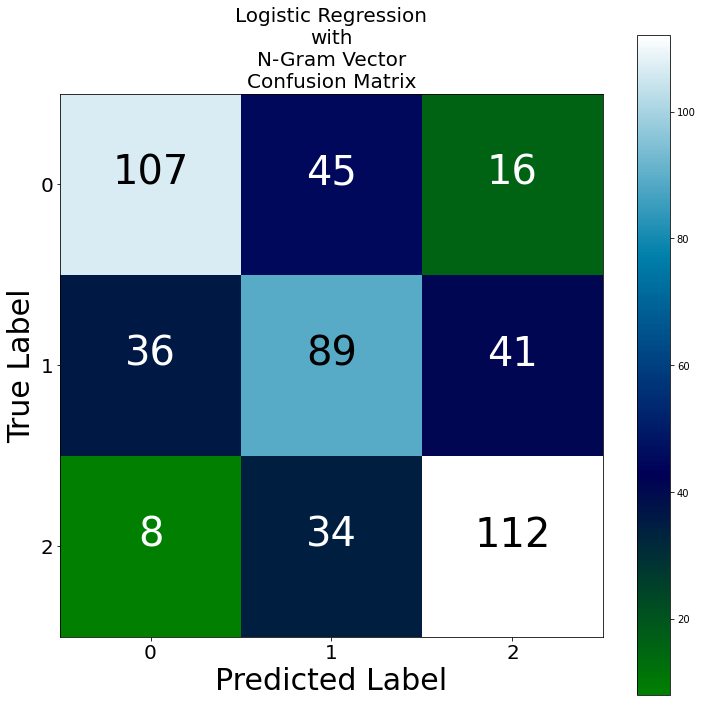

/home/btengana/workspace/MCIT/env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       168
           1       0.50      0.50      0.50       166
           2       0.65      0.68      0.66       154

    accuracy                           0.60       488
   macro avg       0.61      0.61      0.61       488
weighted avg       0.60      0.60      0.60       488



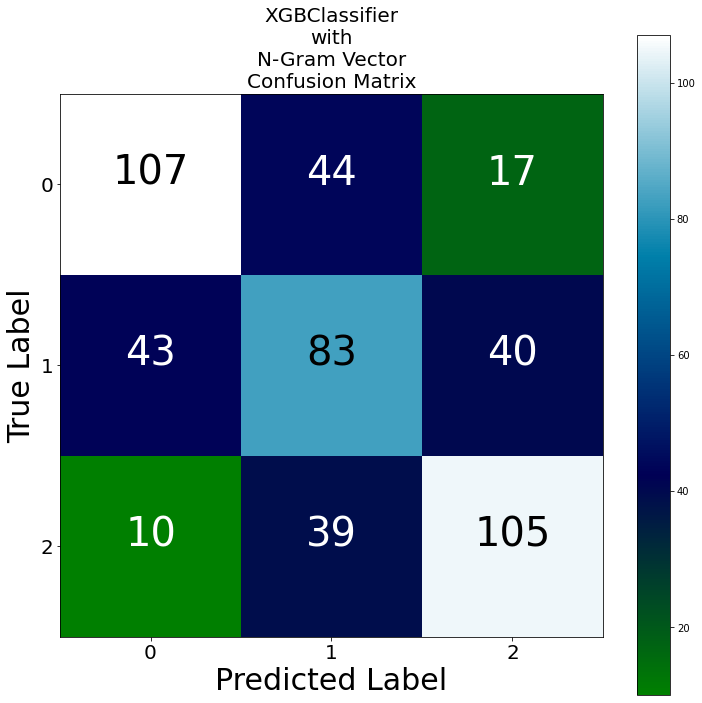

In [37]:
run_models(models, ngram_vectorizer_df, 'N-Gram Vector')

#### Term Frequency (TF) Vector

              precision    recall  f1-score   support

           0       0.70      0.71      0.71       168
           1       0.57      0.49      0.53       166
           2       0.67      0.75      0.71       154

    accuracy                           0.65       488
   macro avg       0.65      0.65      0.65       488
weighted avg       0.65      0.65      0.65       488



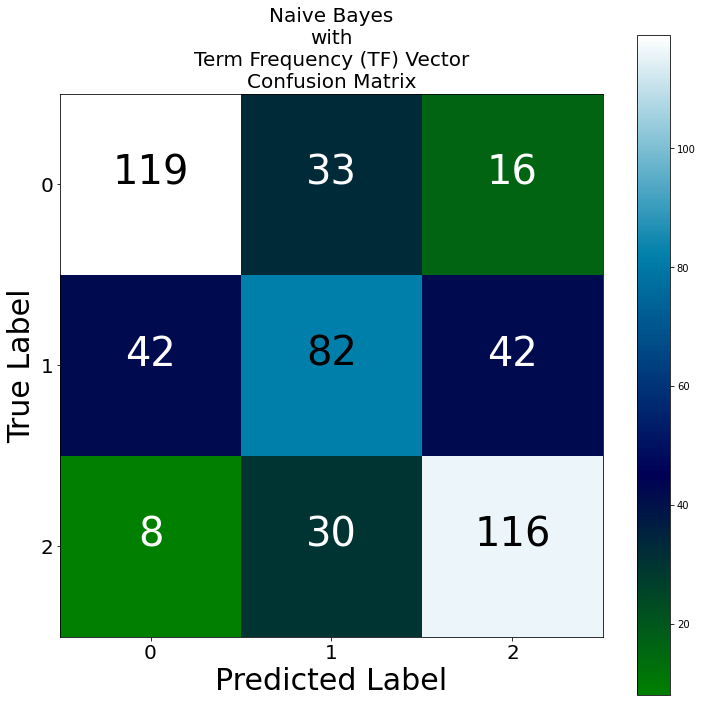

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       168
           1       0.52      0.53      0.53       166
           2       0.68      0.68      0.68       154

    accuracy                           0.62       488
   macro avg       0.62      0.62      0.62       488
weighted avg       0.62      0.62      0.62       488



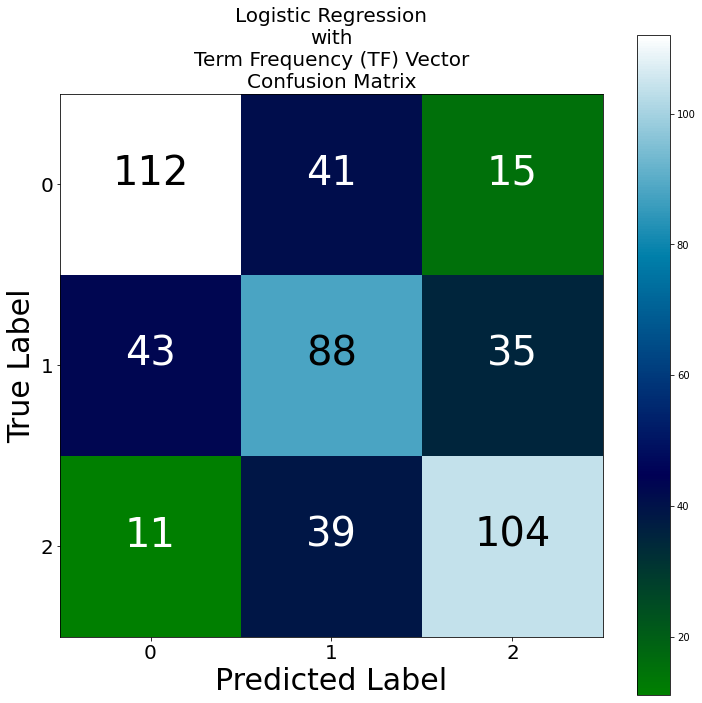

/home/btengana/workspace/MCIT/env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       168
           1       0.52      0.52      0.52       166
           2       0.64      0.66      0.65       154

    accuracy                           0.61       488
   macro avg       0.61      0.61      0.61       488
weighted avg       0.61      0.61      0.61       488



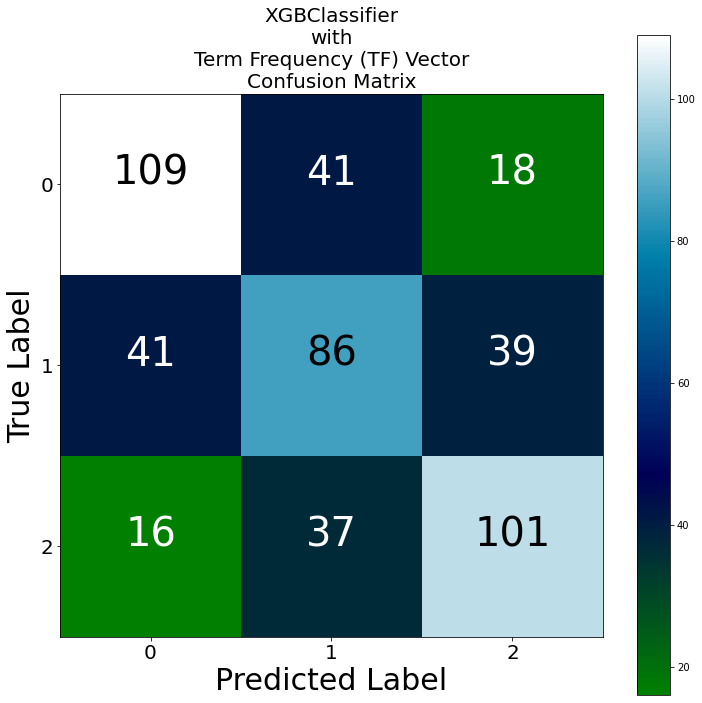

In [38]:
run_models(models, tf_vectorizer_df, 'Term Frequency (TF) Vector')

#### Term Frequency - Inverted Document Frequency (TF-IDF) Vector

              precision    recall  f1-score   support

           0       0.70      0.71      0.71       168
           1       0.57      0.49      0.53       166
           2       0.67      0.75      0.71       154

    accuracy                           0.65       488
   macro avg       0.65      0.65      0.65       488
weighted avg       0.65      0.65      0.65       488



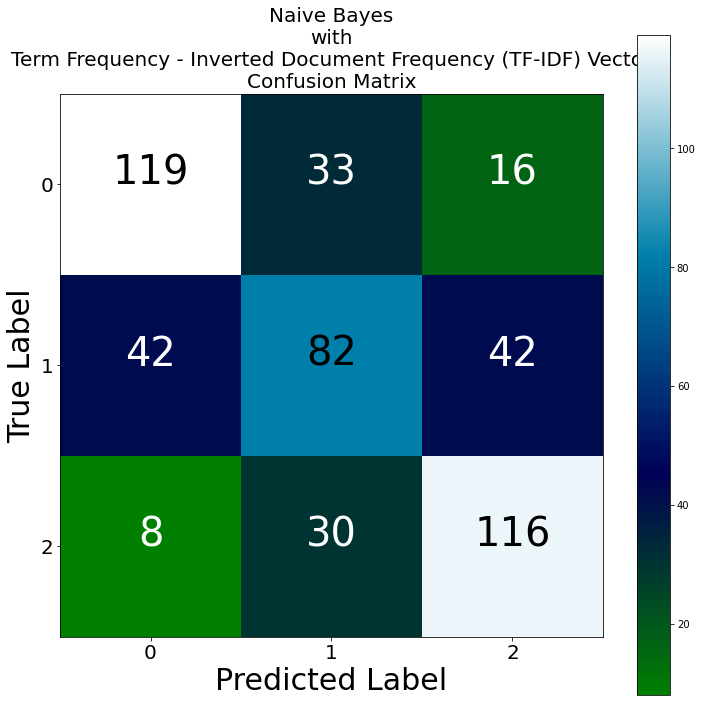

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       168
           1       0.52      0.53      0.53       166
           2       0.68      0.68      0.68       154

    accuracy                           0.62       488
   macro avg       0.62      0.62      0.62       488
weighted avg       0.62      0.62      0.62       488



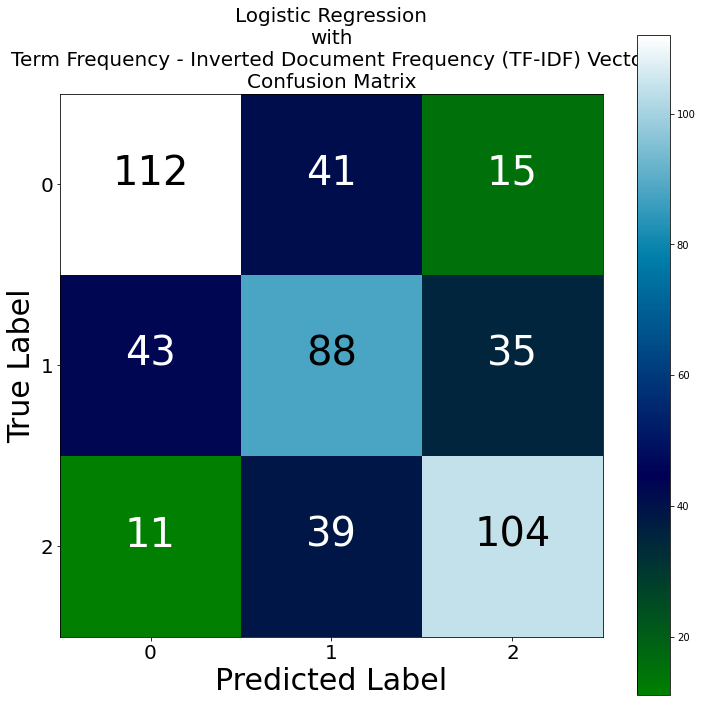

/home/btengana/workspace/MCIT/env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       168
           1       0.52      0.52      0.52       166
           2       0.64      0.66      0.65       154

    accuracy                           0.61       488
   macro avg       0.61      0.61      0.61       488
weighted avg       0.61      0.61      0.61       488



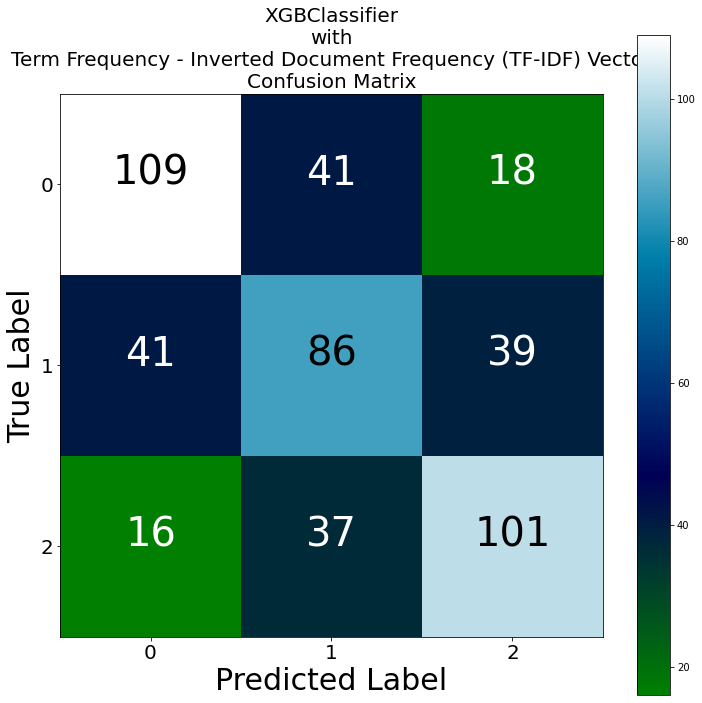

In [39]:
run_models(models, tfidf_vectorizer_df, 'Term Frequency - Inverted Document Frequency (TF-IDF) Vector')